# Introduction to Antenna Simulation 

In this notebook, we will demonstrate how to use Tidy3D to simulate a simple RF antenna and compute key antenna metrics, such as:
* S-parameters
* Impedance
* Field profile
* Directivity and Gain
* Axial Ratio

We will use the patch antenna model designed by Sheen et al. in Reference [1]. A rectangular patch antenna is a type of microstrip antenna consisting of a rectangular conductive patch placed on a dielectric substrate with a ground plane on the opposite side. These antennas are widely used in wireless communication applications due to their simple design, ease of fabrication, and low profile.

<img src="img/PatchAntenna.png" alt="Schematic of the patch antenna"  width="400"/>

In [1]:
# Importing necessary libraries
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.plugins.smatrix as smatrix
from tidy3d.web import run

## Building the Model

### Units and Frequency Settings

The antenna has a primary resonance at f ~ 7.5 GHz and a secondary resonance near f ~ 10 GHz. We will choose a frequency range that encompasses both resonances. 

In [2]:
# Frequency and wavelength parameters
freq_start = 5e9
freq_stop = 11e9
freq0 = (freq_start + freq_stop) / 2
wavelength0 = td.C_0 / freq0

# Target frequencies (also used to define field monitors)
freqs_target = [7.5e9, 10e9]

# Frequency sweep points
freqs = np.linspace(freq_start, freq_stop, 201)

In Tidy3D, the default units are micrometers (µm) and Hertz (Hz). For convenience during setup, we introduce a scaling factor to convert to millimeters (mm), which is more commonly used in RF simulations.

In [3]:
# Scaling used for millimeters
mm = 1e3

### Materials

The dielectric substrate has a constant relative permittivity of 2.2. The metal structures are represented by the perfect electric conductor (PEC) medium. 

In [4]:
# Materials present
medium_air = td.Medium(permittivity=1.0, name="Air")
medium_sub = td.Medium(permittivity=2.2, name="Substrate")
medium_metal = td.PECMedium()

### Geometry and Structures

We follow the dimensions outlined in Reference [1] to create the patch antenna.

In [5]:
# Metal thickness
th = 0.05 * mm

# Substrate parameters
sub_x = 23.34 * mm
sub_y = 40 * mm
sub_z = 0.794 * mm

# Patch parameters
patch_x = 12.45 * mm
patch_y = 16 * mm

# Feed line parameters
feed_x = 2.46 * mm
feed_y = 20 * mm
feed_offset = 2.09 * mm

The structures are created below. 

In [6]:
# Create substrate
substrate = td.Structure(
    geometry=td.Box(center=[0, 0, 0], size=[sub_x, sub_y, sub_z]),
    medium=medium_sub,
    name="Substrate",
)

# Create ground plane
ground_plane = td.Structure(
    geometry=td.Box(center=[0, 0, -(sub_z + th) / 2], size=[sub_x, sub_y, th]),
    medium=medium_metal,
    name="Ground",
)

# Create feed line
feed_line = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=[-patch_x / 2 + feed_offset, -sub_y / 2, sub_z / 2],
        rmax=[-patch_x / 2 + feed_offset + feed_x, -sub_y / 2 + feed_y, sub_z / 2 + th],
    ),
    medium=medium_metal,
    name="Feed line",
)

# Create patch antenna
patch = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=[-patch_x / 2, -sub_y / 2 + feed_y, sub_z / 2],
        rmax=[patch_x / 2, -sub_y / 2 + feed_y + patch_y, sub_z / 2 + th],
    ),
    medium=medium_metal,
    name="Patch",
)

The structures are consolidated into a list below. For best results, we recommend adding any dielectric structures first, followed by metal/PEC structures. This ensures that the metal/PEC overrides the dielectric at the applicable material boundaries.

In [7]:
# List of structures for the simulations
structures_list = [substrate, ground_plane, feed_line, patch]

### Monitors

We define a `FieldMonitor` to observe the field distribution in the patch antenna plane.

In [8]:
# Field monitor to view the electromagnetic fields in the patch plane
monitor_field = td.FieldMonitor(
    center=(0, 0, sub_z / 2),
    size=(td.inf, td.inf, 0),
    freqs=freqs_target,
    name="field",
)

To obtain radiation characteristics such as directivity and gain, use a `DirectivityMonitor`. The `DirectivityMonitor` is set up to surround the entire radiating structure and automatically calculates far-field information through a near-to-far field transformation.

In [9]:
# Define elevation and azimuthal angular observation points
# Theta is the elevation angle and defined relative to global +z axis
theta = np.linspace(0, np.pi, 101)
# Phi is the azimuthal angle and defined relative to global +x axis
phi = np.linspace(-np.pi, np.pi, 201)

# Create the DirectivityMonitor
monitor_directivity = td.DirectivityMonitor(
    center=(0, 0, 0),
    size=(
        30 * mm,
        45 * mm,
        4 * mm,
    ),  # The monitor should enclose the whole structure of interest
    freqs=freqs,
    name="radiation",
    phi=phi,
    theta=theta,
)

19:23:26 CEST WARNING: ℹ️ ⚠️ RF simulations are subject to new license            
              requirements in the future. You have instantiated at least one    
              RF-specific component.                                            

### Boundaries

The simulation is truncated by Perfectly Matched Layers (PMLs) on all sides to absorb the outgoing radiation. Additionally, we introduce air padding of approximately half wavelength thickness around the antenna so that the PMLs do not distort the near field. 

In [10]:
# Padding distance
padding = td.C_0 / freq_start / 2

# Adding padding on each side
sim_x = sub_x + 2 * padding
sim_y = sub_y + 2 * padding
sim_z = sub_z + 2 * padding

# Define PMLs on all sides
boundary_spec = td.BoundarySpec.all_sides(td.PML())

### Grid/Mesh

The grid specification controls how the simulation domain is discretized. We make use of `LayerRefinementSpec` to automatically refine the grid near the metal layers. Otherwise, the grid size in the rest of the domain is set automatically according to the wavelength (typically 20-30 grid steps per wavelength). 

In [11]:
def create_lr_spec(structures_list):
    """Returns LayerRefinementSpec applied to the bounding box of the input structure list"""
    lr_spec = td.LayerRefinementSpec.from_structures(
        structures=structures_list,
        axis=2,  # Layer normal is oriented along the z-axis
        bounds_snapping="bounds",  # Snap grid lines to layer bounds in normal direction
        bounds_refinement=td.GridRefinement(
            dl=th, num_cells=2
        ),  # cell size and num cells at layer boundaries in normal direction
        corner_refinement=td.GridRefinement(
            dl=0.2 * mm, num_cells=2
        ),  # cell size and num cells around in-plane metal corners
    )

    return lr_spec


# Layer refinement for the ground layer
lr_spec_1 = create_lr_spec([ground_plane])

# Layer refinement for the patch antenna layer
lr_spec_2 = create_lr_spec([feed_line, patch])

In [12]:
# Define overall grid specification
grid_spec = td.GridSpec.auto(
    wavelength=wavelength0, min_steps_per_wvl=25, layer_refinement_specs=[lr_spec_1, lr_spec_2]
)

### Lumped Port

The antenna will be excited by a `LumpedPort` positioned at the end of the feed line. 

In [13]:
# Create a lumped port excitation
port = smatrix.LumpedPort(
    name="lumped_port",
    center=[-patch_x / 2 + feed_offset + feed_x / 2, -sub_y / 2, 0],
    size=[feed_x, 0, sub_z],
    voltage_axis=2,  # port is aligned with z-axis
    impedance=50,  # port impedance is 50 Ohms
)

### Define Simulation and TerminalComponentModeler

The `Simulation` object contains all necessary information about the simulation domain that we have defined thus far. Note that the lumped port excitation and the radiation monitor are added later. 

In [14]:
# Create the simulation object
sim = td.Simulation(
    center=[0, 0, 0],
    size=[sim_x, sim_y, sim_z],
    structures=structures_list,
    monitors=[monitor_field],  # Directivity monitor will be added later
    sources=[],  # Lumped port will be added later
    boundary_spec=boundary_spec,
    grid_spec=grid_spec,
    run_time=5e-9,  # Run time should be long enough for total field intensity to fall below shutoff value (default 1e-5)
    plot_length_units="mm",  # This option will make plots default to units of millimeters.
)

              WARNING:  ℹ️ ⚠️ RF simulations are subject to new license           
              requirements in the future. You are using RF-specific components  
              in this simulation.                                               
               - Contains monitors defined for RF wavelengths.                  

The `TerminalComponentModeler` is a wrapper object that automatically conducts a port sweep of the pre-defined `Simulation` in order to generate the full S-parameter matrix. We specify the port and radiation monitor information here. 

In [15]:
# Define TerminalComponentModeler
modeler = smatrix.TerminalComponentModeler(
    simulation=sim,  # Base simulation to run
    freqs=freqs,  # Sweep frequencies points
    ports=[port],  # Include ports here
    radiation_monitors=[monitor_directivity],  # Include radiation monitors here
    verbose=True,
)

### Examine Structures and Mesh

Before running the simulation, it is advisable to inspect the created structure and mesh. 

Here, we examine the structure along its propagation direction and the cross-section at the terminated end of the feed line, which includes the location of the lumped port (green with red arrow).

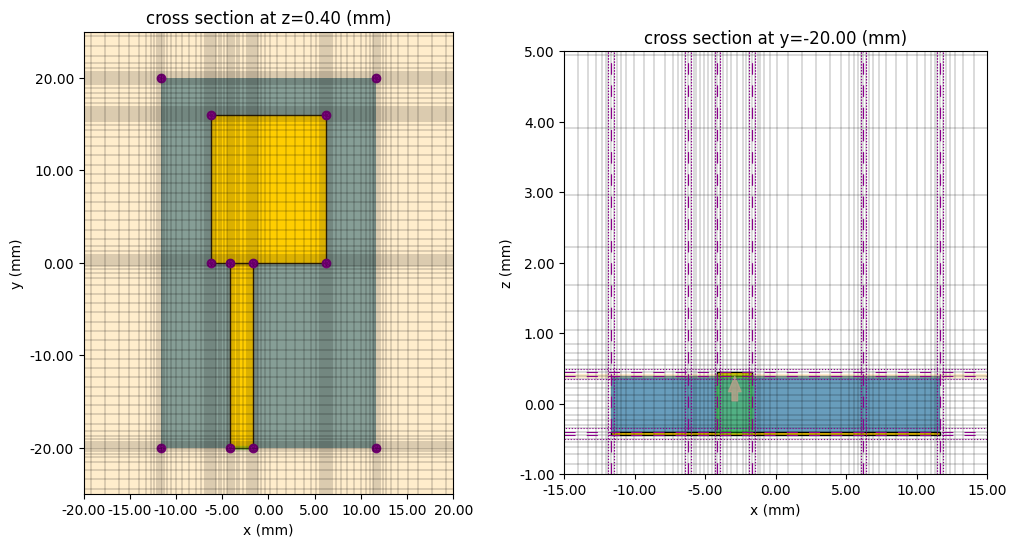

In [16]:
# Create plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the structure and mesh in the x-y plane
modeler.plot_sim(
    z=sub_z / 2,
    ax=ax1,
    monitor_alpha=0.2,
)
sim.plot_grid(z=sub_z / 2, ax=ax1, hlim=[-20 * mm, 20 * mm], vlim=[-25 * mm, 25 * mm])

# Plot the structure and mesh in the x-z plane
modeler.plot_sim(
    y=-sub_y / 2,
    ax=ax2,
    monitor_alpha=0.2,
)
sim.plot_grid(y=-sub_y / 2, ax=ax2, hlim=[-15 * mm, 15 * mm], vlim=[-1 * mm, 5 * mm])
ax2.set_aspect(5)

plt.show()

## Run simulation

Before running, we can estimate the cost of the entire `TerminalComponentModeler` sweep. 

In [17]:
# Estimate cost before running
_ = modeler.batch.estimate_cost()

              WARNING:  ℹ️ ⚠️ RF simulations are subject to new license           
              requirements in the future. You are using RF-specific components  
              in this simulation.                                               
               - Contains a 'LumpedElement'.                                    
               - Contains monitors defined for RF wavelengths.                  

19:23:30 CEST Maximum FlexCredit cost: 0.097 for the whole batch.

We execute the `TerminalComponentModeler` below. The simulation automatically returns the S-parameter matrix. 

In [18]:
# Run the TerminalComponentModeler and obtain S-parameter matrix
s_matrix = modeler.run()

Output()

              Started working on Batch containing 1 tasks.

19:23:32 CEST Maximum FlexCredit cost: 0.097 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

19:23:33 CEST Batch complete.

Output()

In [19]:
# Print real cost after running
_ = modeler.batch.real_cost()

19:23:43 CEST Total billed flex credit cost: 0.082.

System-level results such as the S/Z-parameter matrix and antenna metrics can be accessed directly from the `TerminalComponentModeler` after running.  

To access data from individual simulations in the port sweep, we have to first load the associated batch dataset. This is necessary, for example, to access the field monitor data. 

In [20]:
# Load the batch data to access monitor datasets
batch_data = modeler.batch.load()

              WARNING: 1 file has already been downloaded and will be skipped.  
              To forcibly overwrite existing files, invoke the load or download 
              function with `replace_existing=True`.                            

Output()

## Results

### S-parameters

The `s_matrix` returned by the `TerminalComponentModeler` is the full `fxNxN` matrix, where `f` is the number of frequency points and `N` is the number of ports. In this case, there is only one port. 

Note that Tidy3D uses the physics phase convention. We apply complex conjugate to the calculated S-parameter in order to convert it to the engineering convention. The latter convention is more commonly used in RF and microwave applications. 

In [21]:
# Specify port_in and port_out to get the specific S_ij
S11 = np.conjugate(s_matrix.isel(port_out=0, port_in=0))

# Transform to dB
S11dB = 20 * np.log10(np.abs(S11))

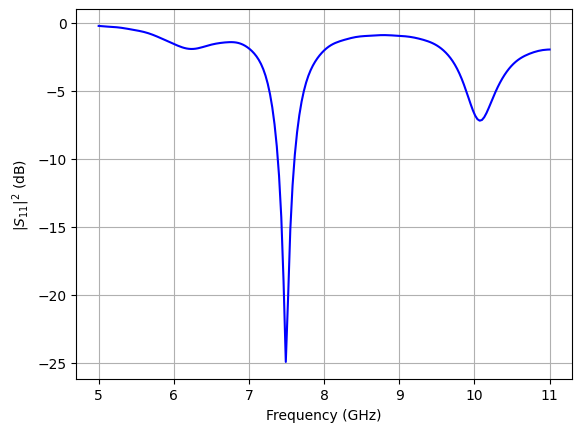

In [22]:
# Plot S11dB
fig, ax = plt.subplots()
ax.plot(
    freqs / 1e9,
    S11dB,
    "-b",
)
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("$|S_{11}|^2$ (dB)")
ax.grid(True)
plt.show()

The first and second resonances are clearly visible in the S11 spectrum. Let's examine the field profile next. 

### Field Distributions

The batch data associated with the `TerminalComponentModeler` contains all the monitor data. It is arranged as a `dict` with one entry for each port excitation. The key names are formatted as `'smatrix_port_name'` where `port_name` is the name of the port excitation. 

In [23]:
# Get simulation data associated with the lumped port excitation
sim_data = batch_data["smatrix_lumped_port"]

Below, we plot the fields at the first two resonances. 

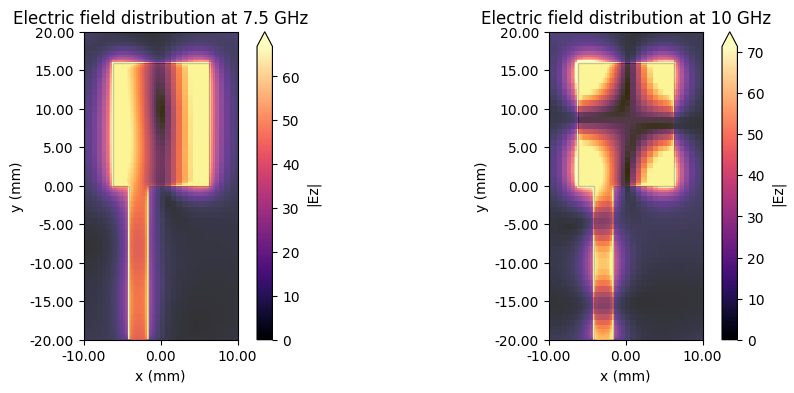

In [24]:
# Plot field monitor data
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
sim_data.plot_field(
    field_monitor_name="field", field_name="Ez", val="abs", f=freqs_target[0], ax=ax1
)
ax1.set_xlim([-10 * mm, 10 * mm])
ax1.set_ylim([-20 * mm, 20 * mm])
ax1.set_title("Electric field distribution at 7.5 GHz")

sim_data.plot_field(
    field_monitor_name="field", field_name="Ez", val="abs", f=freqs_target[1], ax=ax2
)
ax2.set_xlim([-10 * mm, 10 * mm])
ax2.set_ylim([-20 * mm, 20 * mm])
ax2.set_title("Electric field distribution at 10 GHz")
plt.show()

### Impedance

The antenna impedance can be calculated from S11. 

First, we need to de-embed S11 to account for the length of the feed line. The de-embedding calculation shifts the S11 reference plane from the location of the lumped port ($y = -20$ mm) to the end of the feed line where it connects to the patch ($y = 0$ mm). 

In general terms, the de-embedded S-parameter
$$
  S_\text{de-embedded} = S\exp(2jkL)
$$
where $S$ is the original S-parameter, $k$ is the waveguide wavenumber, and $L$ is the shift distance. For simplicity, we assume that the microstrip feed line has a constant effective permittivity of $1.9$ and characteristic impedance of $Z_0=50$ Ohms.  

In [25]:
# Wavenumber associated with microstrip feed line
k_microstrip = 2 * np.pi * freqs * np.sqrt(1.9) / td.C_0

# De-embedded S-parameter
S11_deembedded = S11 * np.exp(1j * 2 * k_microstrip * feed_y)

The antenna impedance can then be calculated using the de-embedded S11.

$$ 
Z_\text{ant} = Z_0 \frac{1+S11_\text{de-embedded}}{1-S11_\text{de-embedded}}
$$

In [26]:
# Antenna impedance
Z_ant = 50 * (1 + S11_deembedded) / (1 - S11_deembedded)

Let's plot the antenna impedance near the first resonance. 

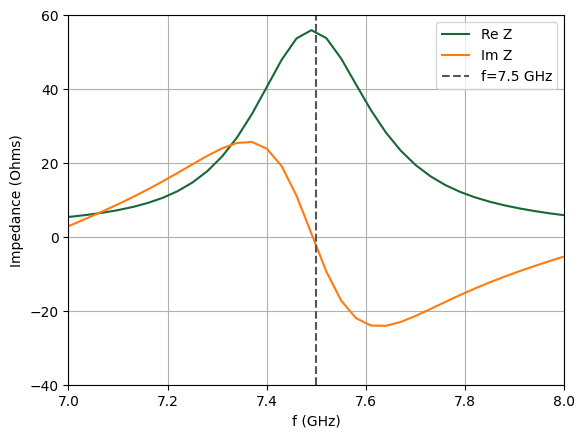

In [27]:
# Plot antenna impedance near first resonance f=7.5 Ghz
fig, ax = plt.subplots()
ax.plot(freqs / 1e9, np.real(Z_ant), label="Re Z")
ax.plot(freqs / 1e9, np.imag(Z_ant), label="Im Z")
ax.axline((7.5, -50), (7.5, 50), ls="--", color="#555555", label="f=7.5 GHz")
ax.set_xlim(7, 8)
ax.set_ylim(-40, 60)
ax.legend()
ax.set_xlabel("f (GHz)")
ax.set_ylabel("Impedance (Ohms)")
ax.grid()
plt.show()

### Far-field Metrics

Directivity, gain and other commonly used antenna metrics are automatically calculated by the `TerminalComponentModeler` when one or more `radiation_monitor` is defined. The user can obtain the far-field metrics by calling the `get_antenna_metrics_data()` method. 

In [28]:
# Get antenna metrics
antenna_metrics = modeler.get_antenna_metrics_data()

Below, we list all of the available antenna far-field metrics for the user's reference. 

In [29]:
# The available antenna metrics quantities are listed below:

# Directivity
directivity = antenna_metrics.directivity

# Radiation efficiency: efficiency accounting for material losses
radiation_efficiency = antenna_metrics.radiation_efficiency

# Gain: radiation efficiency * directivity
gain = antenna_metrics.gain

# Reflection efficiency: efficiency accounting for impedance mismatch
reflection_efficiency = antenna_metrics.reflection_efficiency

# Realized gain: reflection efficiency * gain
realized_gain = antenna_metrics.realized_gain

# Supplied power: power supplied to antenna
supplied_power = antenna_metrics.supplied_power

# Radiated power: power radiated by antenna
radiated_power = antenna_metrics.radiated_power

# Radiation intensity: radiated intensity as a function of angle
radiation_intensity = antenna_metrics.radiation_intensity

# Axial ratio: ratio of major axis to minor axis of polarization ellipse
axial_ratio = antenna_metrics.axial_ratio

# Left and right circular polarization field components
left_polarization = antenna_metrics.left_polarization
right_polarization = antenna_metrics.right_polarization

In the following sections, we will demonstrate how to plot the gain and axial ratio. 

### Antenna Gain

Let's plot the gain at the first resonance (f=7.5 GHz). 

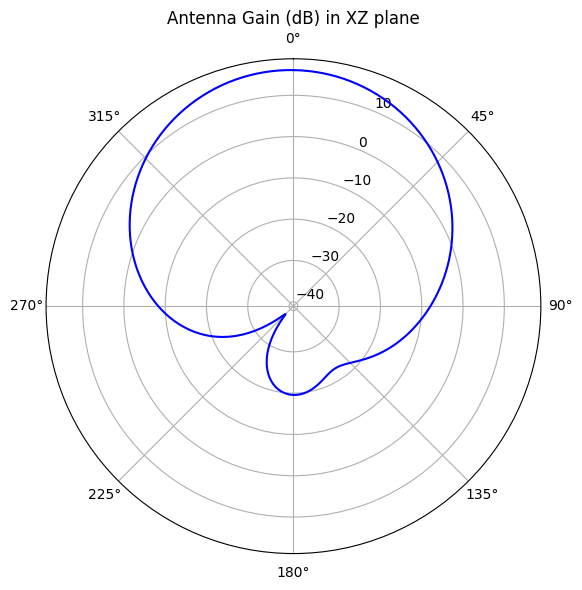

In [30]:
# Plot gain in elevation plane at f=7.5 GHz

# First, extract gain data in the forward and backward directions
gain_F = gain.sel(f=freqs_target[0], phi=0, method="nearest").squeeze()
gain_B = gain.sel(f=freqs_target[0], phi=-np.pi, method="nearest").squeeze()

# Create plot
fig = plt.figure(figsize=(8, 6), tight_layout=True)
ax = fig.add_subplot(111, projection="polar")

# Plot gain in dB
ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi / 2.0)
ax.plot(theta, 20 * np.log10(np.abs(gain_F)), "-b")
ax.plot(-theta, 20 * np.log10(np.abs(gain_B)), "-b")
ax.set_title("Antenna Gain (dB) in XZ plane")
plt.show()

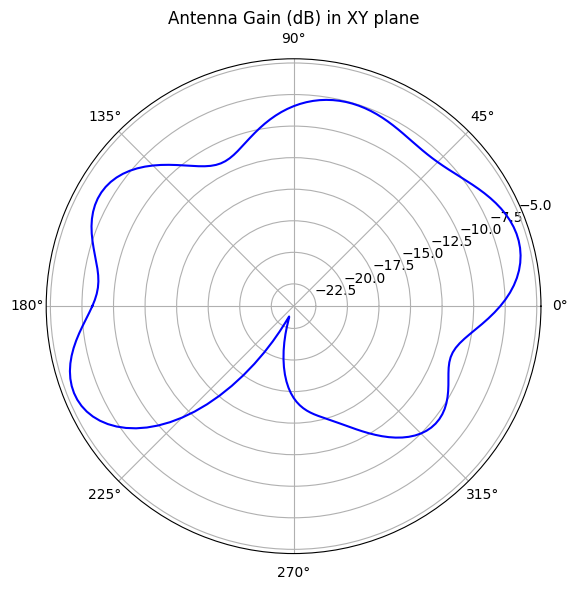

In [31]:
# Plot gain in azimuthal plane at f=7.5 GHz

# Extract gain in azimuthal plane
gain_azi = gain.sel(f=freqs_target[0], theta=np.pi / 2, method="nearest").squeeze()

# Create plot
fig = plt.figure(figsize=(8, 6), tight_layout=True)
ax = fig.add_subplot(111, projection="polar")

# Plot gain in dB
ax.plot(phi, 20 * np.log10(np.abs(gain_azi)), "-b")
ax.set_title("Antenna Gain (dB) in XY plane")
plt.show()

We can also create a 3D plot of the gain. 

In [32]:
# Activate interactive plotting (useful for 3D)
# Requires ipympl library to be installed (comment line below if requirement not met)
%matplotlib widget

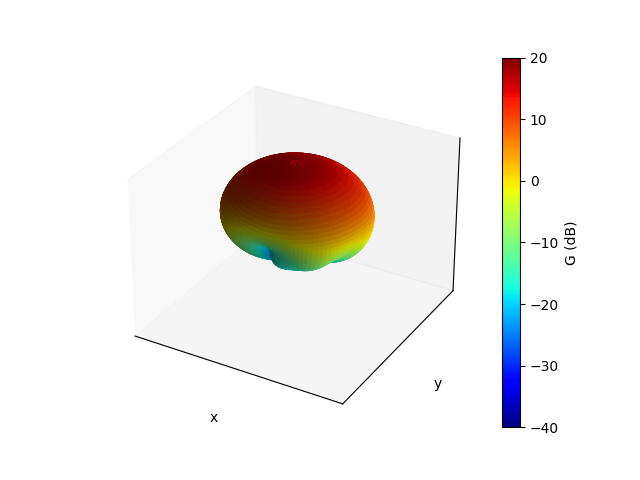

In [33]:
# Create figure and axes
fig_3d = plt.figure()
ax_3d = fig_3d.add_subplot(1, 1, 1, projection="3d")
limits = 1.0
ax_3d.set_xlim(-limits, limits)
ax_3d.set_ylim(-limits, limits)
ax_3d.set_zlim(-limits, limits)
ax_3d.set_xticks([])
ax_3d.set_yticks([])
ax_3d.set_zticks([])
ax_3d.set_xlabel("x")
ax_3d.set_ylabel("y")
ax_3d.set_zlabel("z")

# Rescale gain according to max and min dB values
dB_min, dB_max = (-40, 20)
G = 20 * np.log10(np.abs(gain.sel(f=7.5e9, method="nearest").squeeze()))
G_scaled = np.clip((G - dB_min) / (dB_max - dB_min), a_min=0, a_max=1)

# Create 3D dataset according to scaled gain
phi_s, theta_s = np.meshgrid(phi, theta)
X = G_scaled * np.cos(phi_s) * np.sin(theta_s)
Y = G_scaled * np.sin(phi_s) * np.sin(theta_s)
Z = G_scaled * np.cos(theta_s)

# Select color map
color_map = plt.cm.jet

# Plot surface
surf = ax_3d.plot_surface(
    X,
    Y,
    Z,
    cstride=2,
    rstride=2,
    facecolors=color_map(G_scaled),
)

# Plot color bar
cbar = fig_3d.colorbar(
    plt.cm.ScalarMappable(norm=colors.Normalize(vmax=dB_max, vmin=dB_min), cmap=color_map),
    ax=ax_3d,
    label="G (dB)",
)
plt.show()

In [34]:
# Close 3D figure and deactivate interactive plotting
plt.close(fig_3d)
%matplotlib inline

### Axial Ratio

Let's plot the axial ratio vs frequency for the main lobe (phi, theta = 0)

In [35]:
# Extract axial ratio at main lobe
axial_ratio_main_lobe = axial_ratio.sel(theta=0, phi=0, method="nearest").squeeze()

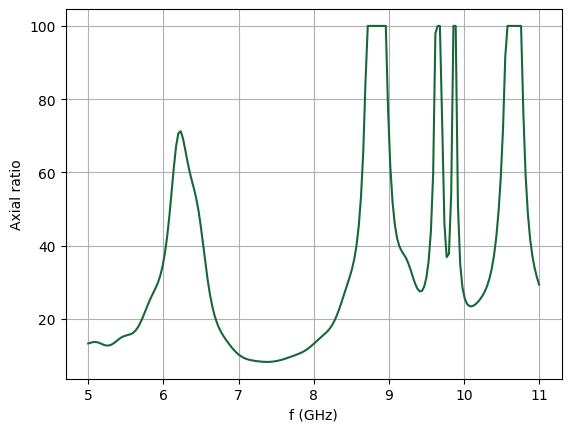

In [36]:
# Plot main lobe axial ratio vs frequency
fig, ax = plt.subplots()
ax.plot(freqs / 1e9, axial_ratio_main_lobe)
ax.grid()
ax.set_xlabel("f (GHz)")
ax.set_ylabel("Axial ratio")
plt.show()

Note that the axial ratio is capped during post-processing at a maximum value of 100, i.e. radiation is effectively linearly polarized. 

## Reference

[1] Sheen, D.M., Ali, S.M., Abouzahra, M.D. and Kong, J.A., 1990. Application of the three-dimensional finite-difference time-domain method to the analysis of planar microstrip circuits. IEEE Transactions on microwave theory and techniques, 38(7), pp.849-857.
